Basic DVF image warping and inversion with ImWIP
==========================================

In this notebook, the basic image warping and inversion functionality of ImWIP is demonstrated. The deformation of the image will be described using a deformation vector field (DVF).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import imwip

We use a sample image from tomopy, but you can replace this with any image

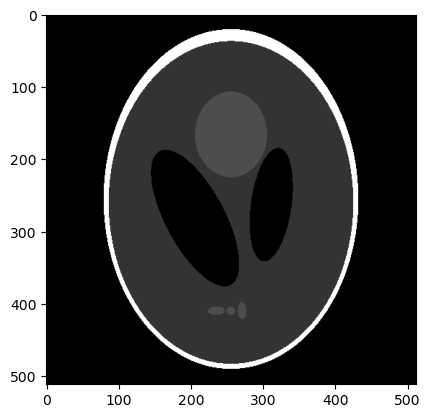

In [2]:
import tomopy
im_size = 512
shepp = tomopy.shepp2d(im_size)[0].astype(np.float32)/255
plt.imshow(shepp, cmap="gray")

An example vector field of the same shape as the image:

In [3]:
u = 10*np.repeat(np.sin(np.linspace(0,4*np.pi, im_size, dtype=np.float32)), im_size).reshape((im_size, im_size))
v = 8*np.repeat(np.cos(np.linspace(0,4*np.pi, im_size, dtype=np.float32)), im_size).reshape((im_size, im_size))

A vector field can be visualized with plt.quiver

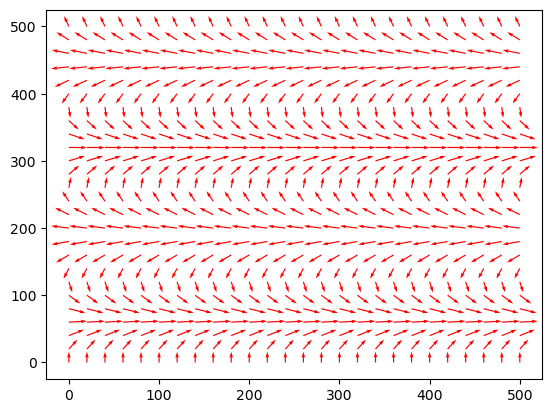

In [4]:
x, y = np.mgrid[:u.shape[1],:u.shape[0]]
plt.quiver(
    x.T[::20, ::20],
    y.T[::20, ::20],
    u[::20, ::20],
    v[::20, ::20],
    color="r",
    angles='xy',
    scale_units='xy',
    scale=0.5
)

Now we can warp the image along this vector field. First we use linear image warping:

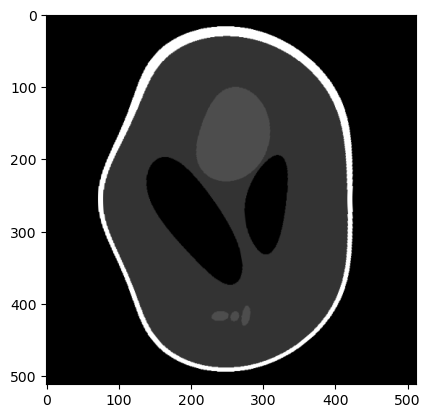

In [5]:
linear_warped_shepp = imwip.warp(shepp, u, v, degree=1)
plt.imshow(linear_warped_shepp, cmap="gray")

Now we perform the same image warp using cubic image warping. Cubic warps produce values outside of the original range so we clip it.

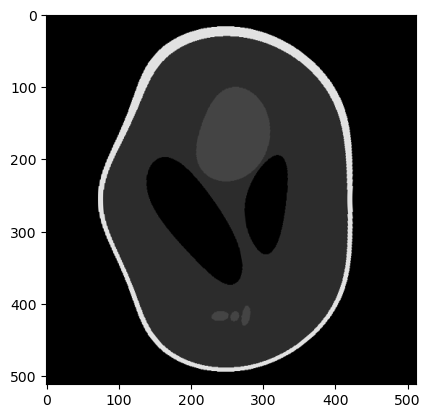

In [6]:
cubic_warped_shepp = imwip.warp(shepp, u, v, degree=3)
np.clip(cubic_warped_shepp, 0, 255, out=cubic_warped_shepp)
plt.imshow(cubic_warped_shepp, cmap="gray")

Inversion using sparse matrix
-------------------------------------------
To invert the image warp, we can exploit the fact that image warping is linear in terms of the image (even if cubic image warping is used). This means that image warping can me represented as a matrix-vector multiplication, and that the inversion comes down to solving a system of linear equations.

In [8]:
A = imwip.warp_matrix(shepp.shape, u, v, degree=3)
A.tocsr() # csr format is efficient for matrix-vector multiplications

<262144x262144 sparse matrix of type '<class 'numpy.float32'>'
	with 4146631 stored elements in Compressed Sparse Row format>

The matrix $A$ has same affect on the image as `imwip.warp(image, u, v)`. We do need to ravel the image such that it becomes a vector:

In [9]:
x = shepp.ravel()
b = A @ x

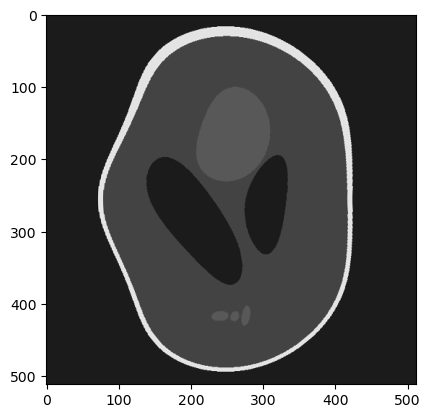

In [10]:
plt.imshow(b.reshape(shepp.shape), cmap="gray")

We can use matrix $A$ to retrieve image $x$ from the warped image $b$, by solving the system
$$Ax=b$$
for $x$.

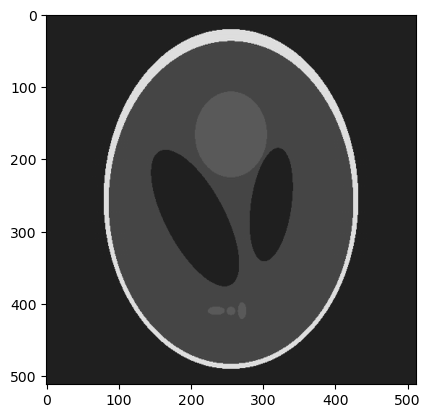

In [11]:
# linear least squarese solver from scipy:
from scipy.sparse.linalg import lsqr

x_reconstructed = lsqr(A, b, iter_lim=20)[0]
plt.imshow(x_reconstructed.reshape(shepp.shape), cmap="gray")

Inversion using matrix-free operator
----------------------------------------------------

The avoid the memory cost of creating and storing `A`, we can use a scipy `LinearOperator` instead.

In [12]:
A = imwip.WarpingOperator2D(u, v, degree=3)
A

<262144x262144 WarpingOperator2D with dtype=float32>

This operator has the same effect as the matrix on vectors when using matrix-vector multiplication, but internally it simply calls `imwip.warp()` for `A @ x` and `imwip.adjoint_warp()` for `A.T @ x`

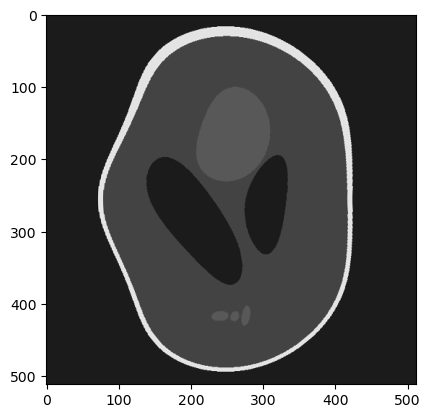

In [13]:
b = A @ x
plt.imshow(b.reshape(shepp.shape), cmap="gray")

We can use this operator to solve the system

$Ax=b$

In [14]:
from scipy.sparse.linalg import lsqr

x_rec = lsqr(A, b, iter_lim=20)[0]

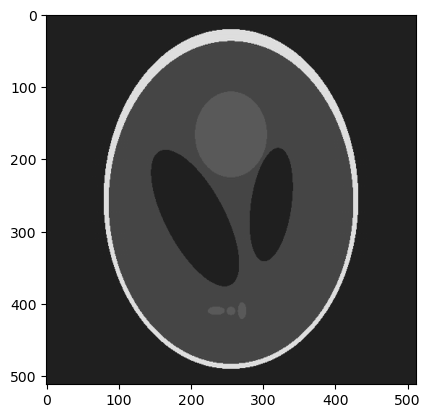

In [15]:
plt.imshow(x_rec.reshape(shepp.shape), cmap="gray")